<a href="https://colab.research.google.com/github/AlumiK/tensorflow2-notebooks/blob/main/08%20Generative%20Adversarial%20Networks/17_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (MNIST)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi -L

GPU 0: GeForce RTX 2080 Ti (UUID: GPU-3cb47403-efa9-71ae-1700-c27de6cb0d0a)


In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0 * 2 - 1, X_test / 255.0 * 2 - 1

BATCH_SIZE = 32
EPOCHS = 30000
PRINT_EVERY = 2000
LATENT_DIM = 100
N, H, W = X_train.shape
D = H * W

X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)
ones = np.ones(BATCH_SIZE)
zeros = np.zeros(BATCH_SIZE)

epoch 1/30000-2000/30000
2000/2000 [==============================] - 75s 37ms/step - d_loss: 0.6993 - d_acc: 0.5312 - g_loss: 0.7236
epoch 2001/30000-4000/30000
2000/2000 [==============================] - 74s 37ms/step - d_loss: 0.6377 - d_acc: 0.7188 - g_loss: 0.8185
epoch 4001/30000-6000/30000
2000/2000 [==============================] - 76s 38ms/step - d_loss: 0.6467 - d_acc: 0.6719 - g_loss: 0.8162
epoch 6001/30000-8000/30000
2000/2000 [==============================] - 76s 38ms/step - d_loss: 0.7005 - d_acc: 0.4844 - g_loss: 0.7981
epoch 8001/30000-10000/30000
2000/2000 [==============================] - 73s 37ms/step - d_loss: 0.6859 - d_acc: 0.5469 - g_loss: 0.7850
epoch 10001/30000-12000/30000
2000/2000 [==============================] - 73s 36ms/step - d_loss: 0.6962 - d_acc: 0.4688 - g_loss: 0.7374
epoch 12001/30000-14000/30000
2000/2000 [==============================] - 73s 36ms/step - d_loss: 0.6760 - d_acc: 0.5625 - g_loss: 0.8073
epoch 14001/30000-16000/30000
2000/2000

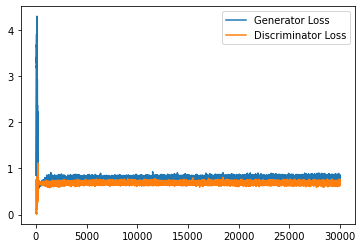

In [ ]:
def build_generator(latent_dim):
    i = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(i)
    x = tf.keras.layers.BatchNormalization(momentum=0.7)(x)
    x = tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.7)(x)
    x = tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.7)(x)
    x = tf.keras.layers.Dense(D, activation='tanh')(x)
    model = tf.keras.models.Model(i, x)
    return model


def build_discriminator(img_size):
    i = tf.keras.layers.Input(shape=(img_size,))
    x = tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(i)
    x = tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(i, x)
    return model


discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
                      metrics=['accuracy'])

generator = build_generator(LATENT_DIM)
z = tf.keras.layers.Input(shape=(LATENT_DIM,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model = tf.keras.models.Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

d_losses = []
g_losses = []
for epoch in range(EPOCHS):
    if epoch % PRINT_EVERY == 0:
        print(f'epoch {epoch + 1}/{EPOCHS}-{epoch + PRINT_EVERY}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(
            PRINT_EVERY, stateful_metrics=['d_loss', 'd_acc', 'g_loss'])
    
    idx = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
    real_imgs = X_train[idx]

    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    fake_imgs = generator.predict(noise)
    
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)
    
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise, ones)
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise, ones)

    d_losses.append(d_loss)
    g_losses.append(g_loss)
  
    values = [('d_loss', d_loss), ('d_acc', d_acc), ('g_loss', g_loss)]
    progbar.add(1, values=values)

plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.show()

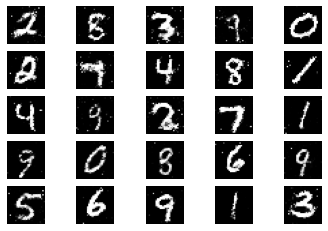

In [ ]:
rows, cols = 5, 5
noise = np.random.randn(rows * cols, LATENT_DIM)
imgs = generator.predict(noise)
imgs = 0.5 * imgs + 0.5

fig, axs = plt.subplots(rows, cols)
idx = 0
for i in range(rows):
    for j in range(cols):
        axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
        axs[i, j].axis('off')
        idx += 1
plt.show()